In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

os.environ["CUDA_VISIBLE_DEVICES"]='0'

GPU device not found
Found GPU at: 


In [3]:
DATA_PATH = "yawn-dataset"

def createDataframe(img_dir, save_as="out.csv"):

    dire_map = {}
    for dire in os.listdir(img_dir):
        if dire == "yawn":
            dire_map[dire] = 0
        elif dire == "no yawn":
            dire_map[dire] = 1

    df = pd.DataFrame(columns = ['img_name', 'path', 'class_label'])
    for dire in os.listdir(img_dir):
        in_dir = os.path.join(img_dir, dire)
        for image in os.listdir(in_dir):
            df = df.append({
                'img_name': image,
                'path': os.path.join(in_dir, image),
                'class_label': dire_map[dire]
            }, ignore_index=True)

    df.to_csv(save_as)
    return df

df = createDataframe(DATA_PATH)

In [4]:
df

,img_name,path,class_label
0,2760.jpg,yawn-dataset\no yawn\2760.jpg,1
1,2761.jpg,yawn-dataset\no yawn\2761.jpg,1
2,2762.jpg,yawn-dataset\no yawn\2762.jpg,1
3,2763.jpg,yawn-dataset\no yawn\2763.jpg,1
4,2764.jpg,yawn-dataset\no yawn\2764.jpg,1
...,...,...,...
5114,995.jpg,yawn-dataset\yawn\995.jpg,0
5115,996.jpg,yawn-dataset\yawn\996.jpg,0
5116,997.jpg,yawn-dataset\yawn\997.jpg,0
5117,998.jpg,yawn-dataset\yawn\998.jpg,0


In [5]:
def load_and_preprocess_from_path_label(path, class_label):

    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (64, 64))

    return image, class_label

def augmentation(ds):
    preprocessing_model = tf.keras.Sequential([])
    preprocessing_model.add(tf.keras.layers.Rescaling(1. / 255))

    ds = ds.map(
        lambda image, class_label:
        (preprocessing_model(image), (class_label))
    )

    return ds

def build_dataset_from_df(df, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((
        [path for path in df["path"]],
        list(df['class_label'])
    ))

    ds = ds.map(load_and_preprocess_from_path_label)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    ds = augmentation(ds)

    return ds  

In [6]:
from sklearn.model_selection import train_test_split

temp_df, valid_df = train_test_split(df, test_size=0.2)
train_df, test_df = train_test_split(temp_df, test_size=0.2)

train_ds = build_dataset_from_df(train_df, 16)
valid_ds = build_dataset_from_df(valid_df, 16)
test_ds = build_dataset_from_df(test_df, 16)

In [7]:
for image, class_label in train_ds.take(10):
    print("Image shape: ", image.shape)
    print("class_label shape: ", class_label)

Image shape:  (16, 64, 64, 3)
class_label shape:  tf.Tensor([1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1], shape=(16,), dtype=int32)
Image shape:  (16, 64, 64, 3)
class_label shape:  tf.Tensor([1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1], shape=(16,), dtype=int32)
Image shape:  (16, 64, 64, 3)
class_label shape:  tf.Tensor([1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1], shape=(16,), dtype=int32)
Image shape:  (16, 64, 64, 3)
class_label shape:  tf.Tensor([1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1], shape=(16,), dtype=int32)
Image shape:  (16, 64, 64, 3)
class_label shape:  tf.Tensor([1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1], shape=(16,), dtype=int32)
Image shape:  (16, 64, 64, 3)
class_label shape:  tf.Tensor([0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1], shape=(16,), dtype=int32)
Image shape:  (16, 64, 64, 3)
class_label shape:  tf.Tensor([1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Image shape:  (16, 64, 64, 3)
class_label shape:  tf.Tensor([1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1], shape=(16,), dtype=int32)
Image shape:  (16, 64, 64, 3)
cl

In [8]:
def make_model(image_size, num_classes=2):

    input_shape = image_size + (3,)

    model = Sequential()
    
    #con 1( input layer)
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    
    #con 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    #con 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    #cov 4
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    #flattening
    model.add(Flatten())
    model.add(Dropout(0.5))
    
    #dense 1
    model.add(Dense(512, activation='relu'))
    
    #dense 2 (output layer)
    model.add(Dense(1, activation='sigmoid'))
    
    return model

mobilenet_model = make_model((64, 64))
mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)       

In [9]:
base_learning_rate = 0.001
batch_size = 16
initial_epochs = 10

callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
optimizer = Adam(learning_rate = base_learning_rate)

mobilenet_model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [10]:
steps_per_epoch = len(train_df) // 16
validation_steps = len(valid_df) // 16

hist = mobilenet_model.fit(
    train_ds,
    epochs = initial_epochs, 
    steps_per_epoch = steps_per_epoch,
    validation_data = valid_ds,
    validation_steps = validation_steps,
    callbacks = callback
).history

Epoch 1/10
204/204 [==============================] - 10s 45ms/step - loss: 0.3005 - accuracy: 0.8652 - val_loss: 0.1467 - val_accuracy: 0.9414
Epoch 2/10
204/204 [==============================] - 9s 42ms/step - loss: 0.1438 - accuracy: 0.9504 - val_loss: 0.0993 - val_accuracy: 0.9717
Epoch 3/10
204/204 [==============================] - 9s 43ms/step - loss: 0.1124 - accuracy: 0.9602 - val_loss: 0.0897 - val_accuracy: 0.9697
Epoch 4/10
204/204 [==============================] - 9s 45ms/step - loss: 0.0972 - accuracy: 0.9629 - val_loss: 0.1352 - val_accuracy: 0.9502
Epoch 5/10
204/204 [==============================] - 9s 45ms/step - loss: 0.0902 - accuracy: 0.9700 - val_loss: 0.1096 - val_accuracy: 0.9590
Epoch 6/10
204/204 [==============================] - 11s 56ms/step - loss: 0.0779 - accuracy: 0.9755 - val_loss: 0.0896 - val_accuracy: 0.9717
Epoch 7/10
204/204 [==============================] - 13s 66ms/step - loss: 0.0735 - accuracy: 0.9743 - val_loss: 0.0759 - val_accuracy: 0.9

In [11]:
#mobilenet_model.save("yawn_model_new.h5")

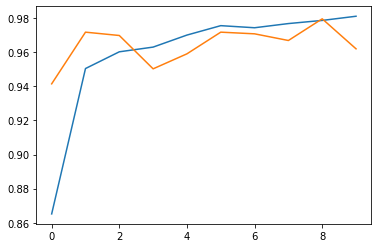

In [12]:
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])

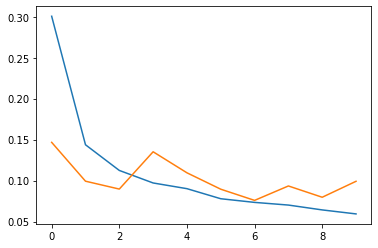

In [13]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])

In [14]:

# Get the number of steps for prediction and evaluation
prediction_steps =1000#tf.data.experimental.cardinality(valid_ds).numpy() // batch_size
evaluation_steps =1000#tf.data.experimental.cardinality(valid_ds).numpy() // batch_size

# Generate predictions
y_pred = (mobilenet_model.predict(valid_ds.take(prediction_steps), steps=prediction_steps) > 0.5).astype(int)

# Get true labels
y_true = np.concatenate([y for x, y in valid_ds.take(evaluation_steps)], axis=0)

# Evaluate the model
results = mobilenet_model.evaluate(valid_ds.take(evaluation_steps), steps=evaluation_steps)
for name, value in zip(mobilenet_model.metrics_names, results):
    print(f'{name}: {value}')

# Calculate F1 score
import sklearn
from sklearn.metrics import f1_score

f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'F1 score: {f1_score}')

1000/1000 [==============================] - 22s 22ms/step - loss: 0.0996 - accuracy: 0.9618
loss: 0.0995555892586708
accuracy: 0.9618124961853027
F1 score: 0.5218982554593145


**Confusion matrix**

In [15]:
pd.DataFrame(sklearn.metrics.confusion_matrix(y_true, y_pred),
             columns=['pred no yawn', 'pred yawn'],
             index=['true no yawn', 'true yawn'])

,pred no yawn,pred yawn
true no yawn,3884,3767
true yawn,4071,4278


Explanation of above table confusion matrix
Top-left cell: "pred no yawn" and "true no yawn"

This cell indicates the number of instances where the model correctly predicted "no yawn" (negative class) when the true label was also "no yawn".
In your case, the count is 4188, meaning there were 4188 instances where the model correctly predicted "no yawn" when the true label was also "no yawn".
Top-right cell: "pred yawn" and "true no yawn"

This cell indicates the number of instances where the model incorrectly predicted "yawn" (positive class) when the true label was "no yawn".
In your case, the count is 4035, meaning there were 4035 instances where the model mistakenly predicted "yawn" when the true label was actually "no yawn".
Bottom-left cell: "pred no yawn" and "true yawn"

This cell indicates the number of instances where the model incorrectly predicted "no yawn" when the true label was "yawn".
In your case, the count is 4011, meaning there were 4011 instances where the model mistakenly predicted "no yawn" when the true label was actually "yawn".
Bottom-right cell: "pred yawn" and "true yawn"

This cell indicates the number of instances where the model correctly predicted "yawn" when the true label was also "yawn".
In your case, the count is 3766, meaning there were 3766 instances where the model correctly predicted "yawn" when the true label was also "yawn".

In [16]:
def predict_class(image):
    image = cv2.imread(image)
    image = cv2.resize(image, (64, 64))
    image = image / 255.0
    print(image.shape)
    
    result = mobilenet_model.predict(np.expand_dims(image, axis=0))
    print(result)
    
    
predict_class('yawn-dataset/yawn/1005.jpg')
predict_class('yawn-dataset/no yawn/2778.jpg')

(64, 64, 3)
[[0.00160754]]
(64, 64, 3)
[[0.8075842]]


In [17]:
steps_per_epoch = len(test_df) // 16
mobilenet_model.evaluate(test_ds, steps = steps_per_epoch)

51/51 [==============================] - 2s 19ms/step - loss: 0.1818 - accuracy: 0.9522


[0.1818152219057083, 0.9522058963775635]

In [18]:
model_json = mobilenet_model.to_json()
with open("mouth_model.json", "w") as json_file:
    json_file.write(model_json)
    
mobilenet_model.save_weights('mouth_model.h5')

In [21]:
mobilenet_model.save("yawn_model_new.h5")